In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geohash

In [47]:
featuredDataset = pd.read_csv('featured-dataset.csv')
featuredDataset = featuredDataset.drop(featuredDataset.columns[0], axis=1)
featuredDataset.head(5)

,year,month,day,time_cat,time_num,time_cos,time_sin,day_cat,day_num,day_cos,day_sin,weekend,x_start,y_start,z_start,location_start,location_end
0,2017,3,22,16.833333333333332:49.999999999999886,0.777778,0.173648,-0.984808,Wednesday,0.396825,-0.797133,0.603804,0,-0.460713,-0.120608,0.879316,eyckx6e80,eycs8byzz
1,2017,5,24,12.333333333333334:20.0,0.569444,-0.906308,-0.422618,Wednesday,0.367063,-0.670981,0.741474,0,0.612977,-0.738237,-0.281542,u0qjdqxen,u0qjf9jxq
2,2017,5,24,12.35:21.0,0.570833,-0.902585,-0.430511,Wednesday,0.367262,-0.671905,0.740637,0,0.612977,-0.738237,-0.281542,u0qjdqxen,u0qjf9jxq
3,2017,5,24,12.35:21.0,0.570833,-0.902585,-0.430511,Wednesday,0.367262,-0.671905,0.740637,0,0.612977,-0.738237,-0.281542,u0qjdqxen,u0qjf9jxq
4,2017,5,24,12.35:21.0,0.570833,-0.902585,-0.430511,Wednesday,0.367262,-0.671905,0.740637,0,0.612977,-0.738237,-0.281542,u0qjdqxen,u0qjf9jxq


In [48]:
featuredDataset.shape

(1537, 17)

### Feature extraction

In [49]:

# Get the longitude and latitude from the geohash
def decodegeo(geo, which):
    if len(geo) >= 6:
        geodecoded = geohash.decode(geo)
        return geodecoded[which]
    else:
        return 0
    
def further_data_prep(df):  

    df['start_lat'] = df['location_start'].apply(lambda geo: decodegeo(geo, 0))
    df['start_lon'] = df['location_start'].apply(lambda geo: decodegeo(geo, 1))
    df['end_lat'] = df['location_end'].apply(lambda geo: decodegeo(geo, 0))
    df['end_lon'] = df['location_end'].apply(lambda geo: decodegeo(geo, 1))
    
    return df

In [67]:
featuredDataset = further_data_prep(featuredDataset)
featuredDataset.head(5)
featuredDataset.columns

Index(['year', 'month', 'day', 'time_cat', 'time_num', 'time_cos', 'time_sin',
       'day_cat', 'day_num', 'day_cos', 'day_sin', 'weekend', 'x_start',
       'y_start', 'z_start', 'location_start', 'location_end', 'start_lat',
       'start_lon', 'end_lat', 'end_lon'],
      dtype='object')

### Train-test split
For Cross Validation, we split the data into 80% train set and 20% test set.

In [51]:
columns_all_features = featuredDataset.columns
columns_X = ['day_num', 'x_start', 'y_start', 'z_start']
columns_y = ['end_lat', 'end_lon']
X = featuredDataset[columns_X]
y = featuredDataset[columns_y]

In [52]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [53]:
print ('X: ({}, {})'.format(*X.shape))
print ('y: ({}, {})'.format(*y.shape))
print ('X_train: ({}, {})'.format(*X_train.shape))
print ('y_train: ({}, {})'.format(*y_train.shape))
print ('X_test: ({}, {})'.format(*X_test.shape))
print ('y_test: ({}, {})'.format(*y_test.shape))

X: (1537, 4)
y: (1537, 2)
X_train: (1229, 4)
y_train: (1229, 2)
X_test: (308, 4)
y_test: (308, 2)


### Machine Learning

In [54]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

#### Grid Search Cross Validation
Grid Search CV implements an exhaustive search over specified parameter values for an estimator.
Important members are fit, predict.

It iterates through a dictionary of hyper parameters and choose the combination that better fits the model.

In [55]:
from sklearn.model_selection import GridSearchCV
# Set the parameters by cross-validation
tuned_parameters = {'n_estimators': [2, 5, 10, 20, 40], 'max_depth': [None, 1, 2, 3, 4], 'min_samples_split': [2, 3, 4, 5, 6]}


# clf = ensemble.RandomForestRegressor(n_estimators=500, n_jobs=1, verbose=1)
gridCV = GridSearchCV(RandomForestRegressor(), tuned_parameters, cv=5, n_jobs=-1, verbose=1)
gridCV.fit(X_train, y_train)
print (gridCV.best_estimator_)

Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=-1)]: Done 232 tasks      | elapsed:    2.1s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=1,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=5, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)


[Parallel(n_jobs=-1)]: Done 625 out of 625 | elapsed:    5.0s finished


#### Model accuracy: R-Squared and Root-mean-squared deviation
R-squared is a statistical measure of how close the data are to the fitted regression line. It ranges from 0 to 1, being 1 the best coefficient.
RMSE is the square root of the mean square error. In other worids the distance, on average, of a data point from the fitted line, measured along a vertical line.

In [56]:
reg = gridCV.best_estimator_
training_accuracy = reg.score(X_train, y_train)
valid_accuracy = reg.score(X_test, y_test)
rmsetrain = np.sqrt(mean_squared_error(reg.predict(X_train),y_train))
rmsevalid = np.sqrt(mean_squared_error(reg.predict(X_test),y_test))
print (" R^2 (train) = %0.6f, R^2 (valid) = %0.6f, RMSE (train) = %0.6f, RMSE (valid) = %0.6f" % (training_accuracy, valid_accuracy, rmsetrain, rmsevalid))

 R^2 (train) = 0.999428, R^2 (valid) = 0.999995, RMSE (train) = 0.204619, RMSE (valid) = 0.023013


#### Forest feature importances
Feature importance shows a coefficient of how much a feature is involved in the decision process of the model. It help us to detect bias in the model, and to make a readjust and better feature selection 

Feature ranking:
1. feature 3 (0.600000)
2. feature 2 (0.300000)
3. feature 1 (0.100000)
4. feature 0 (0.000000)


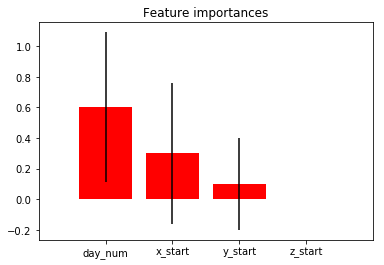

In [57]:
importances = reg.feature_importances_
std = np.std([tree.feature_importances_ for tree in reg.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
feature_names = X_train.columns
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), feature_names)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [58]:
sampleds = pd.DataFrame(featuredDataset, columns=(columns_X + columns_y))
sampleds = sampleds.sample(10)
sampleds

,day_num,x_start,y_start,z_start,end_lat,end_lon
1226,0.390278,0.612977,-0.738237,-0.281542,47.423751,8.555195
783,0.386905,0.612977,-0.738237,-0.281542,47.423751,8.555195
1294,0.391865,0.612977,-0.738237,-0.281542,47.423751,8.555195
696,0.385317,0.612977,-0.738237,-0.281542,47.423751,8.555195
158,0.369444,0.612977,-0.738237,-0.281542,47.423751,8.555195
1272,0.391468,0.612977,-0.738237,-0.281542,47.423751,8.555195
256,0.372024,0.612977,-0.738237,-0.281542,47.423751,8.555195
1300,0.392063,0.612977,-0.738237,-0.281542,47.423751,8.555195
95,0.370437,0.612977,-0.738237,-0.281542,47.423751,8.555195
182,0.370238,0.612977,-0.738237,-0.281542,47.423751,8.555195


In [59]:
y_pred = reg.predict(sampleds.iloc[:,:-2])
y_pred

array([[ 47.41518617,   8.53773234],
       [ 47.41518617,   8.53773234],
       [ 47.41518617,   8.53773234],
       [ 47.41518617,   8.53773234],
       [ 47.41518617,   8.53773234],
       [ 47.41518617,   8.53773234],
       [ 47.41518617,   8.53773234],
       [ 47.41518617,   8.53773234],
       [ 47.41518617,   8.53773234],
       [ 47.41518617,   8.53773234]])

### Save the model
We dump the trained model into a file, so that we can later load and use it without having to fit it again

In [60]:
from sklearn.externals import joblib
joblib.dump(reg, 'random_forest_model.pkl') 

['trained_model.pkl']